In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import legacy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/Users/alix/PycharmProjects/T-ESP-900-esp902-56264-ESP-DJ-4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_dir = "./dataset/"
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6158


In [4]:
img_height = 150
img_width = 150

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=92)

Found 6158 files belonging to 4 classes.
Using 4927 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=92)

Found 6158 files belonging to 4 classes.
Using 1231 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'paper', 'plastic']


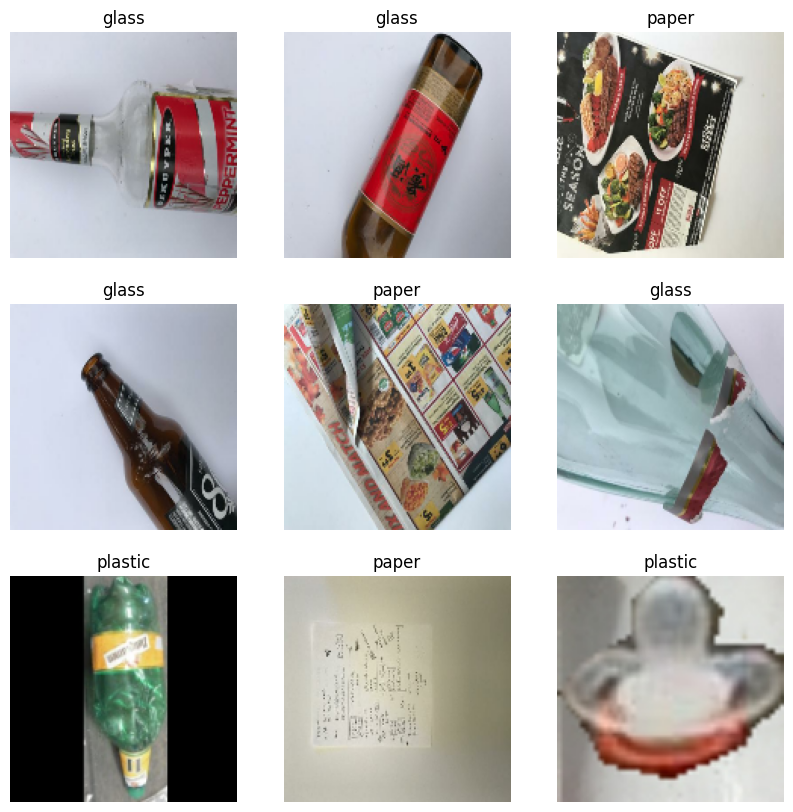

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i, (image, label) in enumerate(zip(images[:9], labels[:9])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.image.resize(image, (img_height, img_width)).numpy().astype("uint8"))
        plt.title(class_names[label])
        plt.axis("off")

plt.show()

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018982729 1.0


In [12]:
num_classes = len(class_names)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

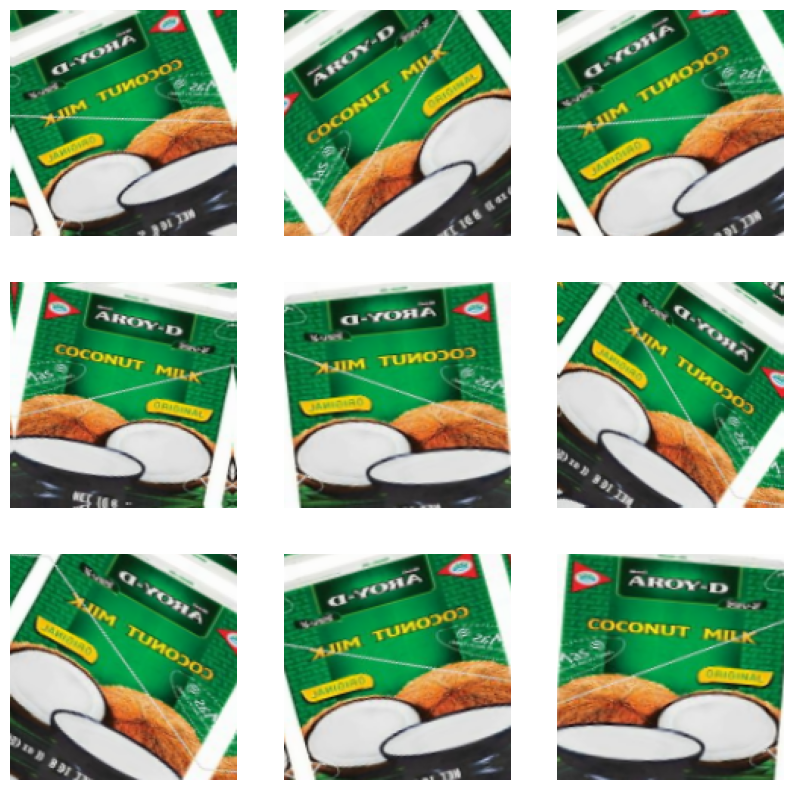

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
model = Sequential([
    data_augmentation,  # Séquence d'augmentation de données
    layers.Rescaling(1./255),  # Normalisation des valeurs des pixels
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [16]:
# Créer l'optimiseur avec le learning rate spécifié
optimizer = legacy.Adam(learning_rate=0.0004)

# Compiler le modèle en utilisant cet optimiseur
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [18]:
epochs = 50
batch_size = 48
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size
)

Epoch 1/50
54/54 [==============================] - 24s 437ms/step - loss: 1.2600 - accuracy: 0.4335 - val_loss: 1.0509 - val_accuracy: 0.5134
Epoch 2/50
54/54 [==============================] - 24s 437ms/step - loss: 1.0230 - accuracy: 0.5472 - val_loss: 1.0025 - val_accuracy: 0.5500
Epoch 3/50
54/54 [==============================] - 23s 427ms/step - loss: 0.9058 - accuracy: 0.6081 - val_loss: 0.8918 - val_accuracy: 0.6174
Epoch 4/50
54/54 [==============================] - 25s 458ms/step - loss: 0.8509 - accuracy: 0.6316 - val_loss: 0.8326 - val_accuracy: 0.6263
Epoch 5/50
54/54 [==============================] - 24s 443ms/step - loss: 0.7928 - accuracy: 0.6661 - val_loss: 0.7898 - val_accuracy: 0.6572
Epoch 6/50
54/54 [==============================] - 24s 442ms/step - loss: 0.7486 - accuracy: 0.6887 - val_loss: 0.6801 - val_accuracy: 0.7197
Epoch 7/50
54/54 [==============================] - 23s 433ms/step - loss: 0.6925 - accuracy: 0.7067 - val_loss: 0.6989 - val_accuracy: 0.7076

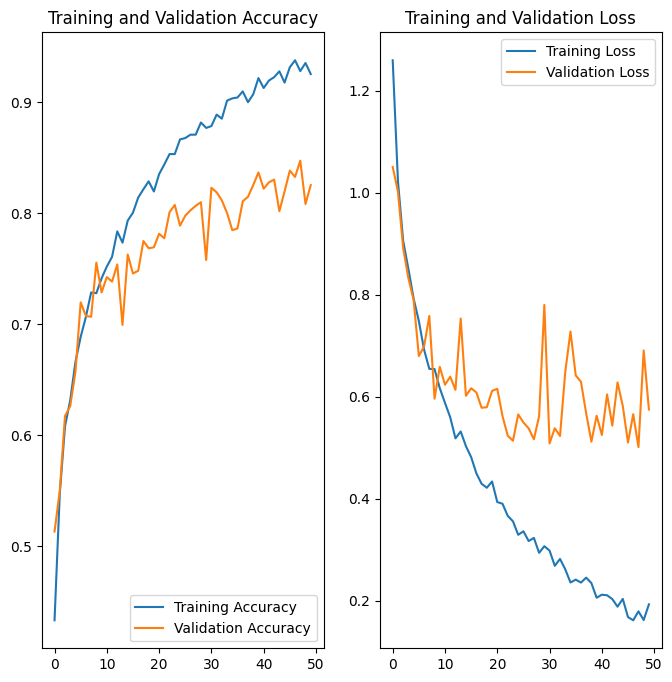

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save('trash.keras')

In [32]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# Charger le modèle pré-entraîné
model_trained = load_model('trash.keras')

# img_path = getRandomPath() 
img_path = "cardboard220.jpg"
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Normalize the image
normalized_img = normalization_layer(img_array)

# Make prediction
predictions = model.predict(normalized_img)
# Afficher les probabilités de chaque classe
print(predictions)

# Déterminer la classe prédite en fonction de la probabilité maximale
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Afficher la classe prédite
print("Classe prédite:", predicted_class)

1/1 [==============================] - 0s 41ms/step
[[9.4177062e-15 2.7077360e-07 1.8803335e-10 9.9999976e-01]]
Classe prédite: plastic
